In [ ]:
!pip install pandas matplotlib yfinance

In [ ]:
# Import libraries yang dibutuhkan
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import yfinance as yf
from math import sqrt
from xgboost import XGBRegressor
from sklearn.model_selection import TimeSeriesSplit

In [ ]:
# Define kode saham dan rentang waktu (1 tahun cukup)
stock_symbol = 'FTT-USD'
start_date = '2022-11-14'
end_date = '2023-11-14'

In [ ]:
# Ambil bagian historical data
df = yf.download(stock_symbol, start=start_date, end=end_date)

[*********************100%%**********************]  1 of 1 completed


In [ ]:
# Pilih kolom 'Open' (butuhnya opening price)
ts = df['Open'].values

In [ ]:
print(ts)

[1.49011004 1.47427404 1.83462596 1.62528396 1.56169605 1.45689595
 1.41655099 1.331622   1.25741601 1.33343196 1.29859698 1.37550104
 1.40119505 1.36450601 1.31575096 1.29403603 1.30423903 1.34015799
 1.29195297 1.30669999 1.31465304 1.38741302 1.39137304 1.45479798
 1.39118099 1.36426103 1.700912   1.51605797 1.52172601 1.48479998
 1.40507495 1.374439   1.35659301 1.14310801 1.07892501 1.04088998
 0.96074402 0.93813401 0.87397301 1.02713299 0.95750499 0.92443198
 0.89456701 0.93113798 0.92116201 0.88572299 0.86019301 0.83896798
 0.84297401 0.85811198 0.86230701 0.88518697 1.00226498 0.94411999
 0.91083902 0.90921497 0.91302401 1.32805502 1.24062502 1.30208302
 1.37791204 1.40603006 1.84186304 2.20495892 2.51167893 2.0784719
 1.76817    2.29456091 2.40961194 2.16448212 2.1053431  2.19820094
 1.83706999 1.96418798 1.88223898 1.98208296 1.91840398 2.05706811
 1.89022601 1.90903294 1.92808294 1.91345203 2.04355907 1.97289002
 1.90584099 1.92961597 2.03915596 1.95197594 1.58625102 1.62159

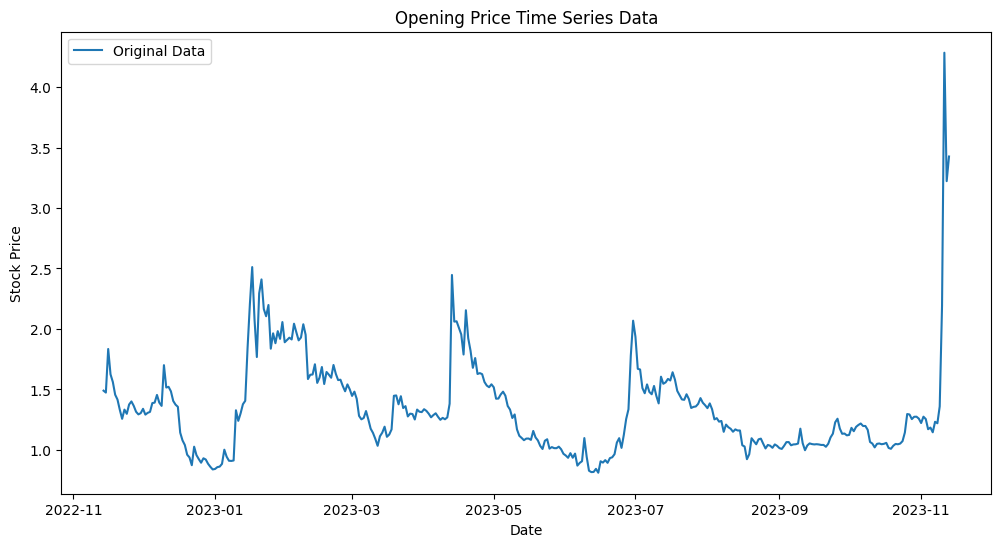

In [ ]:
# Display time series plot dari original data opening price
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Open'], label='Original Data')
plt.title('Opening Price Time Series Data')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [ ]:
# Normalisasi data
scaler = StandardScaler()
ts = scaler.fit_transform(np.array(ts).reshape(-1, 1))

In [ ]:
# Prepare X_train dan X_test
seq_length = 30

X_train = []
y_train = []

for i in range(len(ts) - seq_length):
    X_train.append(ts[i:i + seq_length])
    y_train.append(ts[i + seq_length])

In [ ]:
# Memastikan X_train dan y_train adalah numpy arrays
X_train = np.array(X_train)
y_train = np.array(y_train)

In [ ]:
# Split data menjadi training dan testing (80% training, 20% testing)
train_size = int(len(X_train) * 0.8)
X_train, X_test = X_train[:train_size], X_train[train_size:]
y_train, y_test = y_train[:train_size], y_train[train_size:]

In [ ]:
# Model Architecture
model = keras.Sequential()
model.add(LSTM(128, activation='relu', return_sequences=True, input_shape=(seq_length, 1)))
model.add(Dropout(0.2))  # tambah dropout buat prevent overfitting
model.add(LSTM(128, activation='relu', return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1))

In [ ]:
# Training Parameters
model.compile(optimizer='adam', loss='mean_squared_error')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)  # Early stopping callback

In [ ]:
# Model Training
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/50
7/7 [==============================] - 9s 564ms/step - loss: 0.8799 - val_loss: 0.3039
Epoch 2/50
7/7 [==============================] - 3s 390ms/step - loss: 0.7013 - val_loss: 0.1437
Epoch 3/50
7/7 [==============================] - 2s 250ms/step - loss: 0.5056 - val_loss: 0.0540
Epoch 4/50
7/7 [==============================] - 2s 355ms/step - loss: 0.4126 - val_loss: 0.0429
Epoch 5/50
7/7 [==============================] - 3s 486ms/step - loss: 0.4010 - val_loss: 0.0814
Epoch 6/50
7/7 [==============================] - 2s 283ms/step - loss: 0.3677 - val_loss: 0.0397
Epoch 7/50
7/7 [==============================] - 2s 266ms/step - loss: 0.3066 - val_loss: 0.0375
Epoch 8/50
7/7 [==============================] - 2s 249ms/step - loss: 0.2919 - val_loss: 0.0339
Epoch 9/50
7/7 [==============================] - 2s 278ms/step - loss: 0.3239 - val_loss: 0.0291
Epoch 10/50
7/7 [==============================] - 2s 266ms/step - loss: 0.2699 - val_loss: 0.0236
Epoch 11/50
7/7 [==

In [ ]:
# Model Evaluation
y_pred = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred)

3/3 [==============================] - 1s 25ms/step


In [ ]:
# Menghitung RMSE dan MAE
rmse = sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

In [ ]:
# Data Augmentation (di sini pakai Random Noise)
# tambah random noise ke training data
noise = np.random.normal(0, 0.1, X_train.shape)
X_train_noisy = X_train + noise
model.fit(X_train_noisy, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/50
7/7 [==============================] - 1s 135ms/step - loss: 0.2805 - val_loss: 0.0291
Epoch 2/50
7/7 [==============================] - 1s 134ms/step - loss: 0.2399 - val_loss: 0.0304
Epoch 3/50
7/7 [==============================] - 1s 133ms/step - loss: 0.2590 - val_loss: 0.0389
Epoch 4/50
7/7 [==============================] - 1s 133ms/step - loss: 0.2539 - val_loss: 0.0250
Epoch 5/50
7/7 [==============================] - 1s 129ms/step - loss: 0.2523 - val_loss: 0.0420
Epoch 6/50
7/7 [==============================] - 1s 131ms/step - loss: 0.2377 - val_loss: 0.0258
Epoch 7/50
7/7 [==============================] - 1s 129ms/step - loss: 0.2451 - val_loss: 0.0279
Epoch 8/50
7/7 [==============================] - 1s 126ms/step - loss: 0.2290 - val_loss: 0.0357
Epoch 9/50
7/7 [==============================] - 1s 124ms/step - loss: 0.2480 - val_loss: 0.0321
Epoch 10/50
7/7 [==============================] - 1s 123ms/step - loss: 0.2163 - val_loss: 0.0304
Epoch 11/50
7/7 [==

In [ ]:
# Feature Engineering (di sini pake Adding Volume Data, untuk menambahkan informasi lebih ke analisis time series)
df['Volume'] = df['Volume'] / 1e7
additional_features = df['Volume'].values

In [ ]:
# Concatenate additional features with X_train
additional_features = additional_features.reshape(-1, 1, 1)
additional_features = additional_features[-len(X_train):]
X_train = np.concatenate((X_train, additional_features), axis=1)


In [ ]:
# Ensemble Methods
X_train_2d = X_train.reshape(X_train.shape[0], -1)
xgb_model = XGBRegressor(n_estimators=100, max_depth=5, learning_rate=0.1)
xgb_model.fit(X_train_2d, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [ ]:
from tensorflow.keras.regularizers import l2

# Regularization (L2 Regularization)
model = keras.Sequential()
model.add(LSTM(128, activation='relu', return_sequences=True, input_shape=(seq_length, 1), kernel_regularizer=l2(0.01)))
model.add(LSTM(128, activation='relu', return_sequences=True, kernel_regularizer=l2(0.01)))
model.add(LSTM(128, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dense(1))

In [ ]:
# Menerapkan k-fold cross-validation (buat improve performance dari modelnya)
tscv = TimeSeriesSplit(n_splits=5)
rmses = []
maes = []

for train_index, test_index in tscv.split(X_train):
    X_train_fold, X_val_fold = X_train[train_index, :seq_length], X_train[test_index, :seq_length]
    y_train_fold, y_val_fold = y_train[train_index], y_train[test_index]

    # Define dan train neural network model
    model = keras.Sequential()
    model.add(LSTM(128, activation='relu', return_sequences=True, input_shape=(seq_length, 1)))
    model.add(Dropout(0.2))
    model.add(LSTM(128, activation='relu', return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(128, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1))

    model.compile(optimizer='adam', loss='mean_squared_error')
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    model.fit(X_train_fold, y_train_fold, validation_data=(X_val_fold, y_val_fold), epochs=50, batch_size=32, callbacks=[early_stopping])

    # Evaluasi model
    y_pred = model.predict(X_test)
    y_pred = scaler.inverse_transform(y_pred)

    rmse = sqrt(mean_squared_error(y_val_fold, model.predict(X_val_fold)))
    mae = mean_absolute_error(y_val_fold, model.predict(X_val_fold))

    rmses.append(rmse)
    maes.append(mae)

Epoch 1/50
2/2 [==============================] - 5s 620ms/step - loss: 1.8170 - val_loss: 0.6969
Epoch 2/50
2/2 [==============================] - 0s 149ms/step - loss: 1.7607 - val_loss: 0.5491
Epoch 3/50
2/2 [==============================] - 0s 149ms/step - loss: 1.6432 - val_loss: 0.3250
Epoch 4/50
2/2 [==============================] - 0s 149ms/step - loss: 1.5413 - val_loss: 0.3782
Epoch 5/50
2/2 [==============================] - 0s 153ms/step - loss: 1.3352 - val_loss: 20.6758
Epoch 6/50
2/2 [==============================] - 0s 141ms/step - loss: 1.3361 - val_loss: 1.5724
Epoch 7/50
2/2 [==============================] - 0s 145ms/step - loss: 1.0222 - val_loss: 0.2581
Epoch 8/50
2/2 [==============================] - 0s 152ms/step - loss: 0.9410 - val_loss: 0.1351
Epoch 9/50
2/2 [==============================] - 0s 148ms/step - loss: 0.7560 - val_loss: 0.1275
Epoch 10/50
2/2 [==============================] - 0s 160ms/step - loss: 0.4979 - val_loss: 0.2086
Epoch 11/50
2/2 [=

In [ ]:
# Menghitung average RMSE dari cross-validation
mean_rmse = np.mean(rmses)
mean_mae = np.mean(maes)
print(f"Average RMSE: {mean_rmse}")
print(f"Average MAE: {mean_mae}")

Average RMSE: 0.36673182451152053
Average MAE: 0.267079632626131


In [ ]:
# Predictions untuk test data (X_test)
y_pred_test = model.predict(X_test)
y_pred_test = scaler.inverse_transform(y_pred_test)

3/3 [==============================] - 0s 29ms/step


In [ ]:
print(y_pred_test)

[[1.0538555]
 [1.0613965]
 [1.0678461]
 [1.0940895]
 [1.1165568]
 [1.1192446]
 [1.1106707]
 [1.0997707]
 [1.0888964]
 [1.0799112]
 [1.0728848]
 [1.067788 ]
 [1.0641999]
 [1.0613817]
 [1.0573453]
 [1.0557275]
 [1.0639015]
 [1.0853286]
 [1.1369925]
 [1.2131171]
 [1.2738587]
 [1.3021446]
 [1.3044684]
 [1.2873992]
 [1.2603321]
 [1.2413893]
 [1.2277176]
 [1.2248755]
 [1.2329097]
 [1.2487683]
 [1.2627028]
 [1.2716651]
 [1.2698764]
 [1.2453991]
 [1.2031156]
 [1.1531541]
 [1.1113511]
 [1.0818722]
 [1.0591259]
 [1.0435705]
 [1.0334159]
 [1.0251085]
 [1.0172325]
 [1.0117062]
 [1.0099916]
 [1.011526 ]
 [1.0160614]
 [1.0250512]
 [1.0454955]
 [1.1074834]
 [1.2062832]
 [1.2965572]
 [1.3652558]
 [1.4088007]
 [1.4256637]
 [1.4164007]
 [1.4007031]
 [1.3813858]
 [1.3478875]
 [1.309195 ]
 [1.266275 ]
 [1.2386082]
 [1.2258167]
 [1.2496947]
 [1.4038621]
 [1.7978358]
 [2.1932046]]


In [ ]:
# RMSE dan MAE dari test data
rmse_test = sqrt(mean_squared_error(y_test, y_pred_test))
mae_test = mean_absolute_error(y_test, y_pred_test)

print(f"RMSE for Test Data: {rmse_test}")
print(f"MAE for Test Data: {mae_test}")

RMSE for Test Data: 1.8871855716508046
MAE for Test Data: 1.7828307863221637


In [ ]:
# forecasting
forecast_days = 5
X_forecast = np.copy(X_test[-1])

forecasted_values = []

for _ in range(forecast_days):
    forecasted_value = model.predict(X_forecast.reshape(1, seq_length, 1))
    forecasted_values.append(forecasted_value[0, 0])

    X_forecast = np.roll(X_forecast, -1)
    X_forecast[-1] = forecasted_value

forecasted_values = scaler.inverse_transform(np.array(forecasted_values).reshape(-1, 1))

1/1 [==============================] - 0s 30ms/step


In [ ]:
print(forecasted_values)

[[2.1932044]
 [2.3389559]
 [2.3486593]
 [2.3133163]
 [2.2687457]]


In [ ]:
# date range buat forecast
last_date = df.index[-1]
forecast_dates = pd.date_range(last_date, periods=forecast_days + 1)[1:]

# date range buat test data
test_dates = df.index[-len(y_pred_test):]

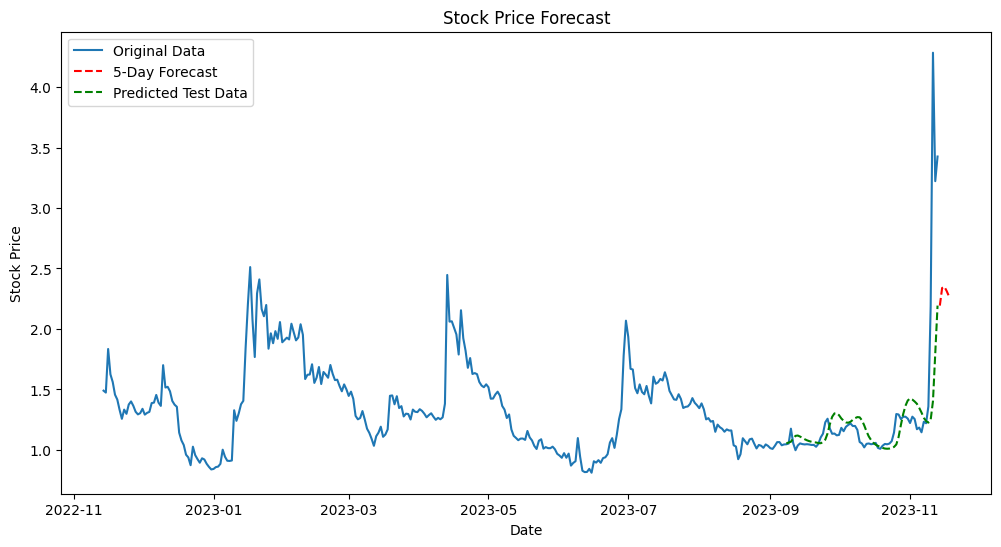

In [ ]:
# Plot dari original data, predicted test data, dan forecasted values
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Open'], label='Original Data')
plt.plot(forecast_dates, forecasted_values, label='5-Day Forecast', linestyle='--', color='red')
plt.plot(test_dates, y_pred_test, label='Predicted Test Data', linestyle='--', color='green') # Adding the predicted test data
plt.title('Stock Price Forecast')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()